In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, jaccard_score, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


path_parent = os.path.dirname(os.getcwd())
data_dir = os.path.join(path_parent,'data')
model_dir = os.path.join(path_parent,'models')
processed_dir = os.path.join(data_dir,'processed')
df_anomaly = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated.csv"))
df_audsome = pd.read_csv(os.path.join(processed_dir,"anomaly_anotated_audsome.csv"))

In [38]:
print("Dataset chosen ...")
data = df_audsome
drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
print("Shape before drop: {}".format(data.shape))
data.drop(drop_col, axis=1, inplace=True)
print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Remove unwanted columns ...
Shape before drop: (3900, 67)
Shape after drop: (3900, 63)


In [39]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
print("Removed Dummy class")
data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Removed Dummy class


Ploting class distribution ..


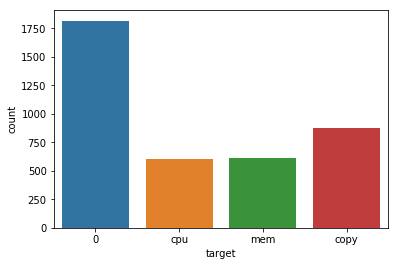

In [40]:
# Plot class distribution
print("Ploting class distribution ..")
sns.countplot(nice_y)

In [41]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [42]:
scaler = StandardScaler()

In [43]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam, Adagrad, SGD
from tensorflow.keras.utils import plot_model

# paramgrid = {
#     "optimizer": ["adam", "adagrad", "sgd"],
#     "learning_r": [0.01, 0.0001 , 0.003, 0.001],
#     "patience" : [4],
#     "batch_size": [32, 64, 128, 256],
#     "epochs": [300],
#     "kernel_init": ['he_uniform', 'he_normal'],
#     "layer_1": [0, 50, 100],
#     "layer_2": [0,  50, 100],
#     "layer_3": [0,  50, 100],
#     "layer_0": [0, 200, 100, 50],
#     "drop": [0, 0.1, 0.2, 0.3, 0.4],
#     "loss": ["categorical_crossentropy"],
#     "activation_1": ['relu', 'elu', 'selu'],
#     "out_activation":["sigmoid"]
# }

# Extracted params
batch_size = 256
epochs = 1000

# Reverse one hot encoding
def reverse_oh(y_oh):
    decode = []
    for r in y_oh:
        # print(r)
        result = np.where(r == 1.)[0]
        # print(result)
        #check if network asigned more than one or non labels
        if len(result) > 1 or len(result) == 0:
            if len(result) > 1:
                result = np.array([result[0]])  # select first class
            elif len(result) == 0:
                result = np.array([0])

        decode.append(result[0])
    return decode

# {"optimizer": "sgd",
#  "learning_r": 0.001,
#  "patience": 3,
#  "batch_size": 128,
#  "epochs": 200,
#  "kernel_init": "he_normal",
#  "layer_1": 50,
#  "layer_2": 50,
#  "layer_3": 0,
#  "layer_0": 50,
#  "drop": 0,
#  "loss": "categorical_crossentropy",
#  "activation_1": "relu",
#  "out_activation": "sigmoid"}
#
#
# {"optimizer": "sgd",
#  "learning_r": 0.01,
#  "patience": 4,
#  "batch_size": 32,
#  "epochs": 300,
#  "kernel_init": "he_normal",
#  "layer_1": 0,
#  "layer_2": 50,
#  "layer_3": 100,
#  "layer_0": 50,
#  "drop": 0.3,
#  "loss": "categorical_crossentropy",
#  "activation_1": "elu",
#  "out_activation": "sigmoid"}

def dnn_aspide(optimizer='adam', #adam, adagrad, sgd
               learning_r = 0.01,
              kernel_init='he_normal',
              layer_1 = 0,
              layer_2 = 50,
              layer_3 = 100,
              layer_0 = 50,
              drop = 0.3,
              loss='categorical_crossentropy',
              activation_1 = 'relu', # elu, selu
              out_activation='sigmoid'):
    y_oh = pd.get_dummies(y, prefix='target')
    # print(np.asarray(X).shape[1], len(y_oh.nunique()))
    n_inputs, n_outputs = X.shape[1], len(y_oh.nunique())
    model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=2,activation=activation_1, input_shape=n_inputs, kernel_initializer=kernel_init))
    model.add(Dense(layer_0, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
    if drop:
        model.add(Dropout(drop))
    if layer_1:
        model.add(Dense(layer_1, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_2:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    if layer_3:
        model.add(Dense(layer_2, input_dim=n_inputs, kernel_initializer=kernel_init, activation=activation_1))
        if drop:
            model.add(Dropout(drop))
    model.add(Dense(n_outputs, activation=out_activation))
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_r)
    if optimizer == 'adagrad':
        opt = Adagrad(learning_rate=learning_r)
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_r)
    else:
        opt = Adam(learning_rate=0.01)
    model.compile(optimizer = opt, loss=loss, metrics=['accuracy', 'categorical_crossentropy', 'binary_crossentropy'])
    # history = model.fit(np.asarray(X), np.asarray(y_oh),
    #           batch_size=batch_size,
    #           epochs=epochs,
    #           callbacks = [early_stopping, reduce_lr],
    #           verbose=1) #verbose set to 1 will show the training process
    # df_history = pd.DataFrame(h.history)
    # df_history
    return model

# model = dnn_aspide()
# model = KerasClassifier(build_fn=dnn_aspide, verbose=0)


Starting fold 1
Scaling data ....
Start training ....
Accuracy score is: 0.9887179487179487
Ballanced accuracy score is: 0.9892609937441669
Jaccard score: 0.9887179487179487
Full classification report
              precision    recall  f1-score   support

           0     0.9934    0.9912    0.9923       454
         cpu     0.9868    0.9934    0.9901       151
         mem     0.9682    1.0000    0.9838       152
        copy     0.9953    0.9725    0.9838       218

    accuracy                         0.9887       975
   macro avg     0.9859    0.9893    0.9875       975
weighted avg     0.9889    0.9887    0.9887       975

Confusion matrix
####################################################################################################
Starting fold 2
Scaling data ....
Start training ....
Accuracy score is: 0.46564102564102566
Ballanced accuracy score is: 0.25
Jaccard score: 0.46564102564102566
Full classification report
              precision    recall  f1-score   support

  

/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
/home/gabriel/anaconda3/envs/pyaspide/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

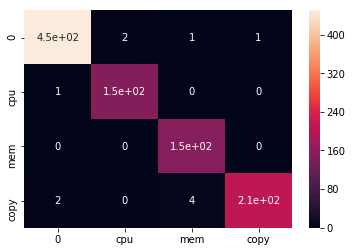

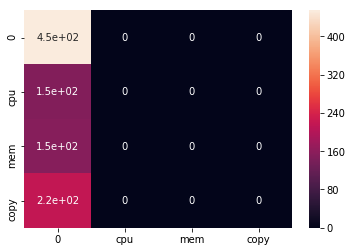

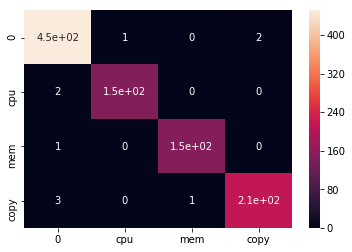

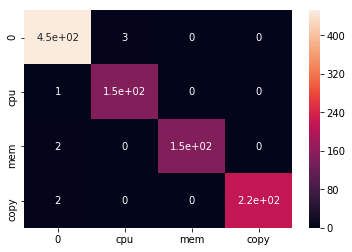

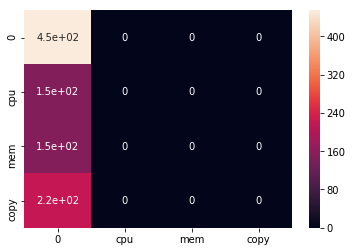

In [44]:
# skFold = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=21)
ml_method = 'dnn'
patience = 3
print("="*100)
clf_models = []
report = {
    "Accuracy": [],
    "BallancedAccuracy": [],
    "Jaccard": []
}
fold = 1
for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    print("Starting fold {}".format(fold))
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    y_oh_train = pd.get_dummies(ytrain, prefix='target')
    y_oh_test = pd.get_dummies(ytest, prefix='target')
    print("Scaling data ....")
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    print("Start training ....")
    early_stopping = EarlyStopping(monitor="loss", patience = 3)# early stop patience
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
    model = KerasClassifier(build_fn=dnn_aspide, verbose=0, callbacks=[early_stopping, reduce_lr])
    history = model.fit(np.asarray(Xtrain), np.asarray(y_oh_train),
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping, reduce_lr],
              verbose=0, validation_data=(np.asarray(Xtest), np.asarray(y_oh_test))) #verbose set to 1 will show the training process

    # Classification Report
    y_pred = model.predict(Xtest)
    # print(y_pred)
    # print(y)
    # y_pred = y_pred.round()
    # y_pred = reverse_oh(y_pred)
    # print(y_pred)
    # # print(decode)
    print("Accuracy score is: {}".format(accuracy_score(ytest, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(ytest, y_pred)))
    print("Jaccard score: {}".format(jaccard_score(ytest, y_pred)))
    print("Full classification report")
    print(classification_report(ytest, y_pred,digits=4, target_names=definitions))
    report = classification_report(ytest, y_pred, digits=4, output_dict=True, target_names=definitions)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_Fold_{}.csv".format("DNN", fold)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)

    print("Confusion matrix")
    cf_matrix = confusion_matrix(ytest, y_pred)
    sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    cf_fig = "{}_cf_Fold{}.png".format("DNN", fold)
    sns_cf.figure.savefig(os.path.join(model_dir, cf_fig))
    plt.show()

    # Saving History
    df_history = pd.DataFrame(history.history)
    history_name = "DNN_Fold{}_history.csv".format(fold)
    df_history.to_csv(os.path.join(model_dir,history_name), index=False)

    fold+=1
    print("#"*100)

Saving topology


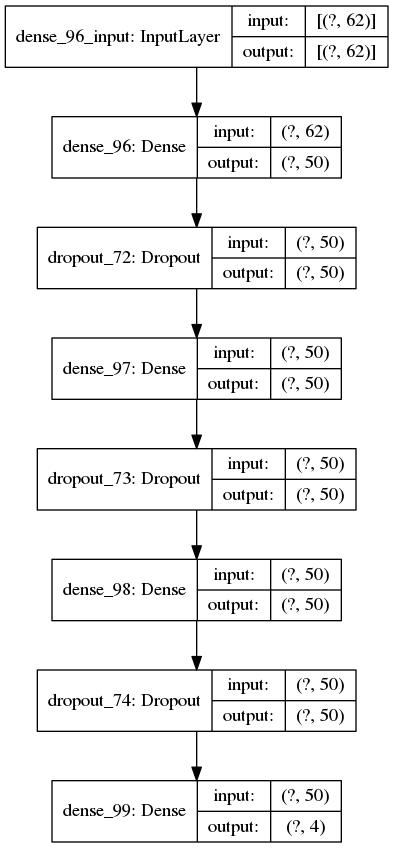

In [45]:
print("Saving topology")
topology_name = "{}_topology.png".format("DNN")
plot_model(model.model, to_file=os.path.join(model_dir, topology_name), show_shapes=True)